In [1]:
# Load the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import math

# Increase the number of output rows to match the number of columns
pd.set_option('display.max_rows', 135)

# loading the dataset (takes some time). csv file location is hardcoded relative to the repo root.
# Data is loaded into the pandas DataFrame object - a convenient notation automagically 
# taking care of NaNs where applicable. Missing data in GDT is mostly related to either:
# 1) variable redundancy (ex. some records can be classified as both assassination and kidnapping),
# meaning not all records have all variables filled in, or
# 2) unreliable sources, mostly dealing with date/time variables
print('Loading data...')
data = pd.read_csv('Data/globalterrorismdb_0617dist.csv', engine='python')
print('Dataset loaded!')

Loading data...
Dataset loaded!


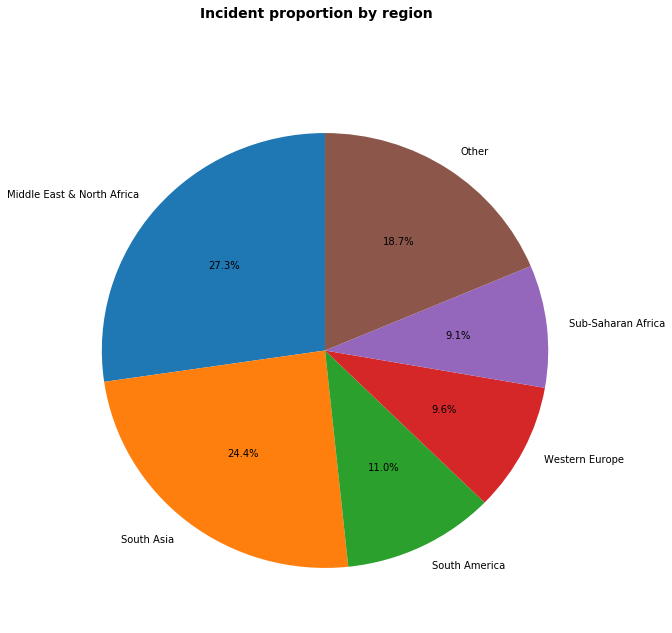

In [2]:
# Question 1: What is the distribution of recorded terrorism incidents 
# between 1970 and 2016 by major geographical regions?

# Iterate over regions ('region_txt' variable) and count the number of incidents
sum_by_region = []
for region in np.unique(data['region_txt']):
    sum_by_region.append((region, data.loc[data['region_txt'] == region].shape[0] / data.shape[0] * 100))
    
# Sort results in an ascending order
sum_by_region = sorted(sum_by_region, key=operator.itemgetter(1))

# Sum regions with smallest incident ratio (here: less than 15% total), 
# so that only regions with proportionally bigger incident ratio 
# are specified. The rest are put in the 'Other' category.
smallest_threshold = 15
other_regions = 0
while other_regions < smallest_threshold:
    other_regions += sum_by_region[0][1]
    sum_by_region.pop(0)
    
# Sort results in a descending order
sum_by_region = list(reversed(sum_by_region))
sum_by_region.append(('Other', other_regions))

# Plot results
fig = plt.figure(figsize=(10,10))   
plt.pie([float(value[1]) for value in sum_by_region], labels=[value[0] for value in sum_by_region],
        autopct='%1.1f%%', startangle=90)
fig.suptitle('Incident proportion by region', fontsize=14, fontweight='bold')
plt.show()

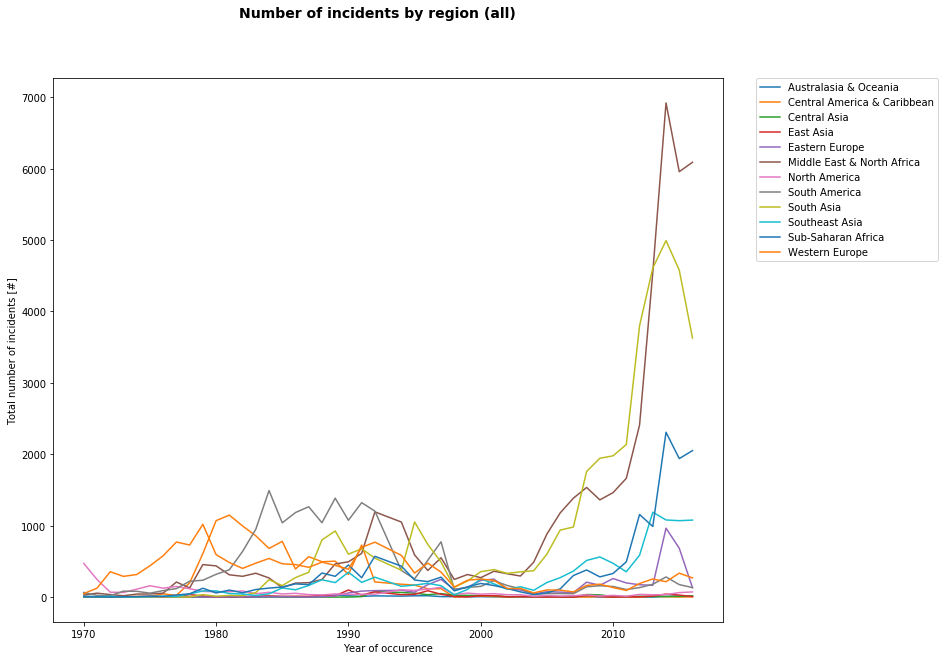

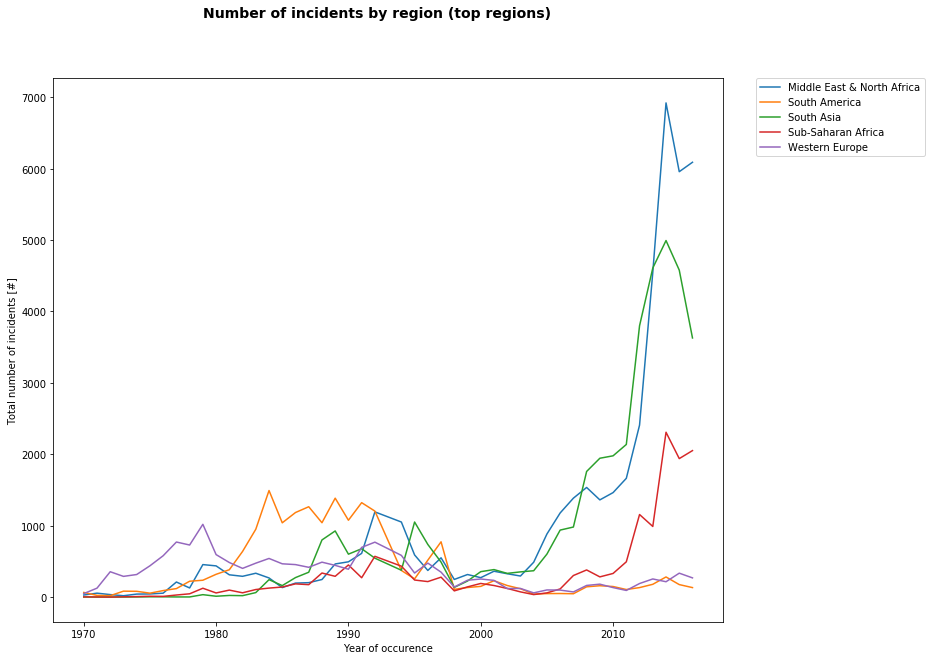

In [3]:
# Question 2: How did the number of incidents in every region change each year?

# Find the sorted list of years of incidents ('iyear' variable)
year_list = sorted(np.unique(data['iyear']))

# Iterate over regions ('region_txt' var) and count the incidients 
# that occurred in a given year
region_series = {}
for region in np.unique(data['region_txt']):
    series = []
    region_idx = data['region_txt'] == region
    for year in year_list:
        series.append((data.loc[(data['iyear'] == year) & region_idx].shape[0]))
    region_series[region] = series

# Plot results for all regions
fig = plt.figure(figsize=(12,10))
for region, series in region_series.items():
    plt.plot(year_list,series, label=region)
fig.suptitle('Number of incidents by region (all)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Year of occurence')
plt.ylabel('Total number of incidents [#]')
plt.show()

# Plot results for top regions (answer to Question 1)
fig = plt.figure(figsize=(12,10))
for region, series in region_series.items():
    if (region in [top_region[0] for top_region in sum_by_region]):
        plt.plot(year_list, series, label=region)
fig.suptitle('Number of incidents by region (top regions)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Year of occurence')
plt.ylabel('Total number of incidents [#]')
plt.show()

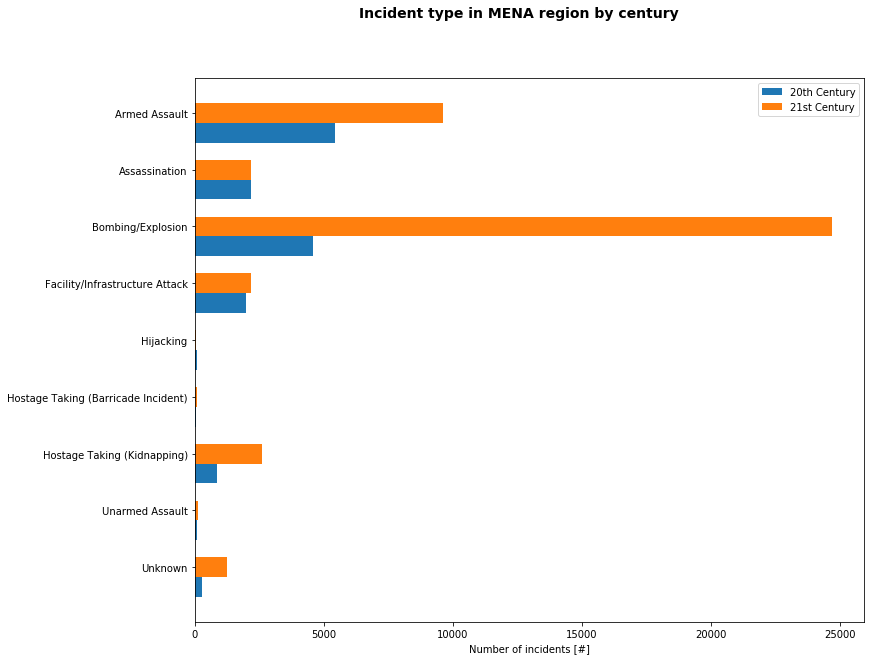

In [4]:
# Question 3: It seems that the number of incidents in the Middle East & North Africa (MENA)
# heavily varies by century. Was there any change in terrorism type in this region?

# Find records of incidents in MENA ('region_txt' var) and divide them by century ('iyear' var)
mena20c_index = (data['region_txt'] == 'Middle East & North Africa') & (data['iyear'] < 2001)
mena21c_index = (data['region_txt'] == 'Middle East & North Africa') & (data['iyear'] > 2000)

# Iterate over all incident types ('attacktype1_txt', 'attacktype2_txt', 'attacktype3_txt';
# ex. assassination, kidnapping, hijaking) for all identified records.
mena_attacks = {}
# Incidents for 20th century
for attack_type in reversed(np.unique(data['attacktype1_txt'])):
    mena_attacks[attack_type] = [data.loc[mena20c_index &
                                        (data['attacktype1_txt'] == attack_type) |
                                        (data['attacktype2_txt'] == attack_type) |
                                        (data['attacktype3_txt'] == attack_type) ].shape[0]]

# Incidents for 21th century    
for attack_type in np.unique(data['attacktype1_txt']):
    mena_attacks[attack_type].append(data.loc[mena21c_index &
                                        (data['attacktype1_txt'] == attack_type) |
                                        (data['attacktype2_txt'] == attack_type) |
                                        (data['attacktype3_txt'] == attack_type) ].shape[0])
    
# Plot results
fig = plt.figure(figsize=(12,10))
bar20c = plt.barh(np.arange(len(mena_attacks)), [attack_type[0] for attack_type in mena_attacks.values()], 0.35)
bar21c = plt.barh(np.arange(len(mena_attacks))+0.35, [attack_type[1] for attack_type in mena_attacks.values()], 0.35, 
                 tick_label=([attack_type for attack_type in mena_attacks.keys()]))
fig.suptitle('Incident type in MENA region by century', fontsize=14, fontweight='bold')
plt.legend((bar20c[0], bar21c[0]), ('20th Century', '21st Century'))
plt.xlabel('Number of incidents [#]')
plt.show()


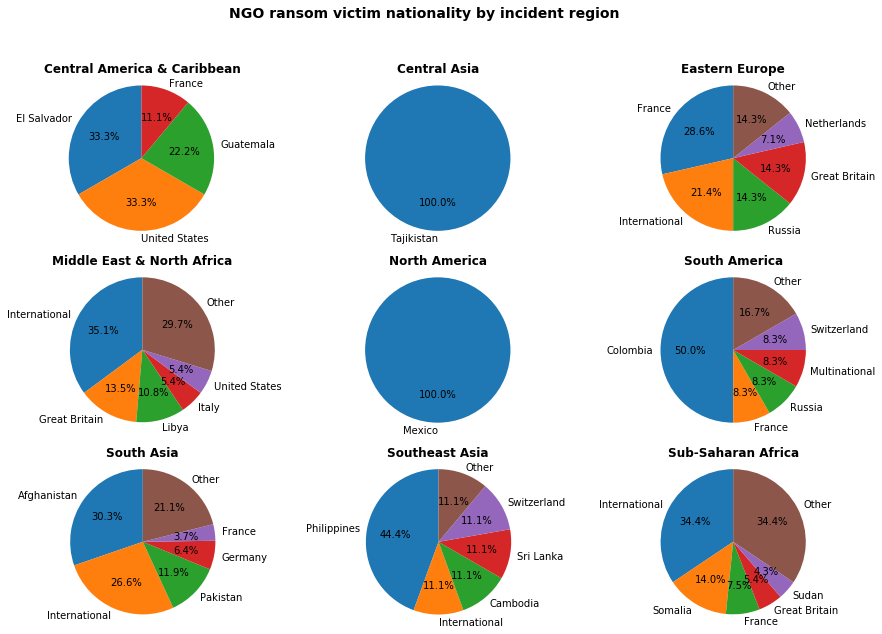

In [5]:
# Question 4: Are Non-Government Organization (NGO) employees targeted based on their nationality?

# Find records of kidnapping ('attacktype1_txt' only; we're looking at primarily ransom incidents)
# that targeted NGO employees ('targtype1_txt' only; same as above)
ransom_idx = ((data['attacktype1_txt'] == 'Hostage Taking (Kidnapping)') &
             (data['targtype1_txt'] == 'NGO'))
ransom_sum = {}

# Iterate over regions ('region_txt') and count the number of incidents.
for region in np.unique(data['region_txt']):
    ransom_sum[region] = data['natlty1_txt'].loc[ransom_idx & (data['region_txt'] == region)].value_counts()
    if np.logical_not(ransom_sum[region].size):
        ransom_sum.pop(region, None)

# Once again, display only top 5 (=top_n) nationalities in each region; group the rest.
top_n = 5
for region in ransom_sum.keys():
    if ransom_sum[region].shape[0] > top_n:
        temp = ransom_sum[region].nlargest(top_n)
        temp.set_value('Other', ransom_sum[region].nsmallest(ransom_sum[region].shape[0]-top_n).sum())
        ransom_sum[region] = temp

# Plot results
subplot_width = 3
fig, ax = plt.subplots(math.ceil(len(ransom_sum.keys())/subplot_width),subplot_width, figsize=(15,10))
idx_x = 0
idx_y = 0
for region in ransom_sum.keys():
    ax[idx_x,idx_y].pie([victims for victims in ransom_sum[region].values], 
            labels=[country for country in  ransom_sum[region].keys()],
            autopct='%1.1f%%', startangle=90)
    ax[idx_x,idx_y].axis('equal')
    ax[idx_x,idx_y].set_title(region, fontweight='bold')
    if idx_y == 2:
        idx_x += 1
        idx_y = 0
    else:
        idx_y += 1
fig.suptitle('NGO ransom victim nationality by incident region', fontsize=14, fontweight='bold')
plt.show()

# Note: These results should be plotted against more specific incident locations (countries).
# For example, it's hard to tell if Columbians were targeted based on their nationality
# or whether those incidents occured primarily in Columbia.


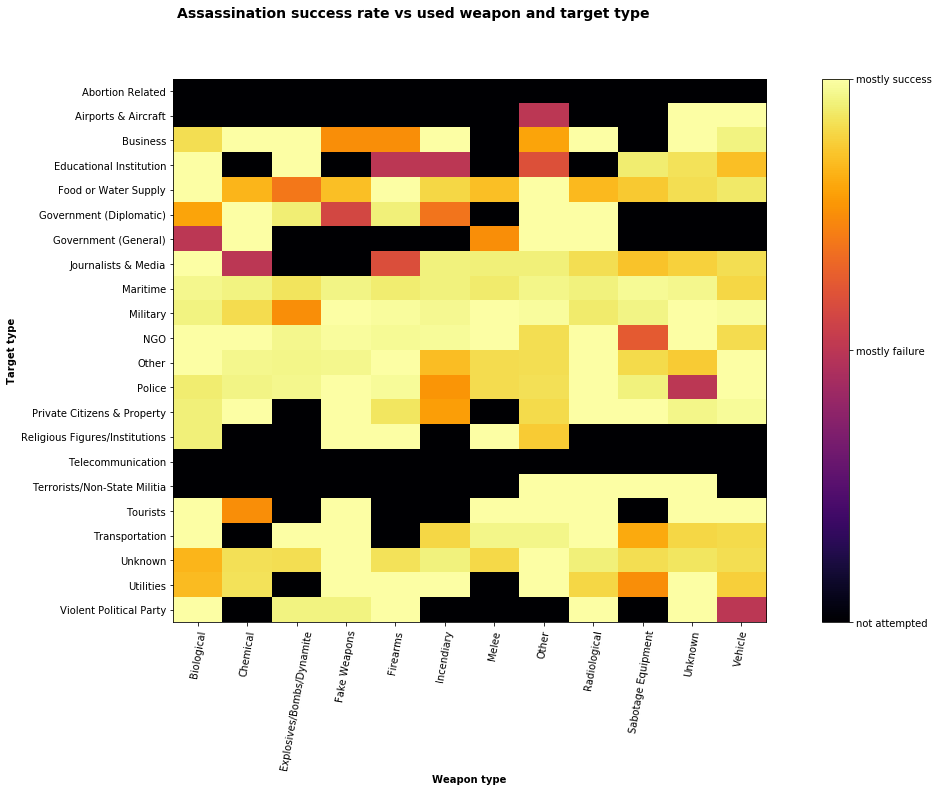

In [6]:
# Question 5: What was the most successful weapon used in assassination incidents?
# Did it matter who was the target (ex. government official, tourists)?

# Assassination type incident has highest hierarchy position, (see GTD documentation)
# so we check only 'targtype1_txt' and 'attacktype1_txt'.
assn_idx = ((data['attacktype1_txt'] == 'Assassination'))

# Iterate over all assassination incidents and count the occurrence by used weapon type 
# (multiple variables) and target type. For each cell calculate the overall success ratio
# ('success_ratio' variable).
assn_dict = {}
assn_dict['target'] = np.unique(data['targtype1_txt']) # x axis
assn_dict['weapon'] = np.unique(data['weaptype1_txt']) # y axis
assn_dict['success_ratio'] = []
for weapon in assn_dict['weapon']:
    weapon_idx = (assn_idx & 
        (data['weaptype1_txt'] == weapon) |
        (data['weaptype2_txt'] == weapon) |
        (data['weaptype3_txt'] == weapon) |
        (data['weaptype4_txt'] == weapon))
    for target in assn_dict['target']:
        target_idx = ((data['targtype1_txt']==target) & weapon_idx)
        total = data.loc[target_idx].shape[0]
        if total:
            success = data.loc[target_idx & (data['success'] == 1)].shape[0]
            assn_dict['success_ratio'].append(100*success/total)
        else:
            # There were no assasination incidents
            assn_dict['success_ratio'].append(-100)

# Reshape data to be of size (target_types, weapon_types)
assn_dict['success_ratio'] = np.reshape(assn_dict['success_ratio'], (len(assn_dict['target']), len(assn_dict['weapon'])))
assn_dict['weapon'][-1] = 'Vehicle' # make the last entry name shorter

# Plot results
fig = plt.figure(figsize=(20,10))
plt.imshow(assn_dict['success_ratio'], interpolation='none', aspect=10./20, vmin=-100, vmax=100)
plt.xlabel('Weapon type', fontweight='bold')
plt.xticks(range(len(assn_dict['weapon'])),assn_dict['weapon'], rotation=80)
plt.ylabel('Target type', fontweight='bold')
plt.yticks(range(len(assn_dict['target'])),assn_dict['target'], rotation=0)

# Display colorbar
plt.inferno()
cb = plt.colorbar()
cb.set_ticks([-100, 0, 100])
cb.set_ticklabels(['not attempted', 'mostly failure', 'mostly success'])

fig.suptitle('Assassination success rate vs used weapon and target type', fontsize=14, fontweight='bold')
plt.show()